# Guiding questions

In Columbia, for every field, what has race/ethnicity representation looked like in the last twenty years?

In [6]:
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Let's first convert the GSS export, a table representation of a nested tree, into a nested dictionary.

In [11]:
# Read in CSV
df = pd.read_csv(
    '../../data/GSS_Export_Broad_RaceandEthnicity.csv', 
    header=4, # start table from 4th row of data
    skipfooter=4, # ignore last 4 lines of data (footer)
    engine='python', # default pandas engine does not support skipfooter
    index_col=False, # don't use first column (year) as dataframe index
)

# Rename columns for better readability
df.columns = ['Year', 'Institution Name', 'Broad Fields', 'Race and Ethnicity', 'Count']

# Remove Institution Name column (we know it's all Columbia)
df.drop('Institution Name', axis=1, inplace=True)

df['Count'] = df['Count'].str.replace(',', '') # remove all thousands-commas
df = df.astype({ 'Count': int }) # Convert column "Count" to integers

df.head()

,Year,Broad Fields,Race and Ethnicity,Count
0,2016,Total for selected values,Total for selected values,6498
1,2016,Total for selected values,Total for selected values,6498
2,2016,Biological sciences,Total for selected values,790
3,2016,Biological sciences,Ethnicity and race unknown or not stated,12
4,2016,Biological sciences,"Foreign nationals holding temporary visas, reg...",235


In [12]:
# Format: { year: { field: { race_ethnicity: count } } }
counts = defaultdict(lambda: defaultdict(dict))

# loop through all rows in dataframe
for _, row in df.iterrows():
    year = row['Year']
    field = row['Broad Fields']
    race_ethnicity = row['Race and Ethnicity']
    count = row['Count']
    counts[year][field][race_ethnicity] = count

In [39]:
years = [year for year in range(1994, 2017)]

fields = list(df['Broad Fields'].unique())

race_ethnicities = list(df['Race and Ethnicity'].unique())
race_ethnicities.remove('Total for selected values')

Let's now do some exploratory analysis on racial/ethnic diversity in every field.

In [41]:
def stack_proportions(ax, field, legend=False, exclude=None):
    stacks = {r: [] for r in race_ethnicities if r != exclude}
    
    for year in years:
        field_counts = counts[year][field]
        total = field_counts['Total for selected values'] - field_counts.get(exclude, 0)
        for r in race_ethnicities:
            if r != exclude:
                stacks[r].append(field_counts.get(r, 0) / total)

    ax.stackplot(years, stacks.values(), labels=stacks.keys())
    
    if legend:
        ax.legend()
        ax.set_title('LEGEND')
        return

    ax.set(title=field, xlabel='Year')
    
    # Format y tick labels to be percentages
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

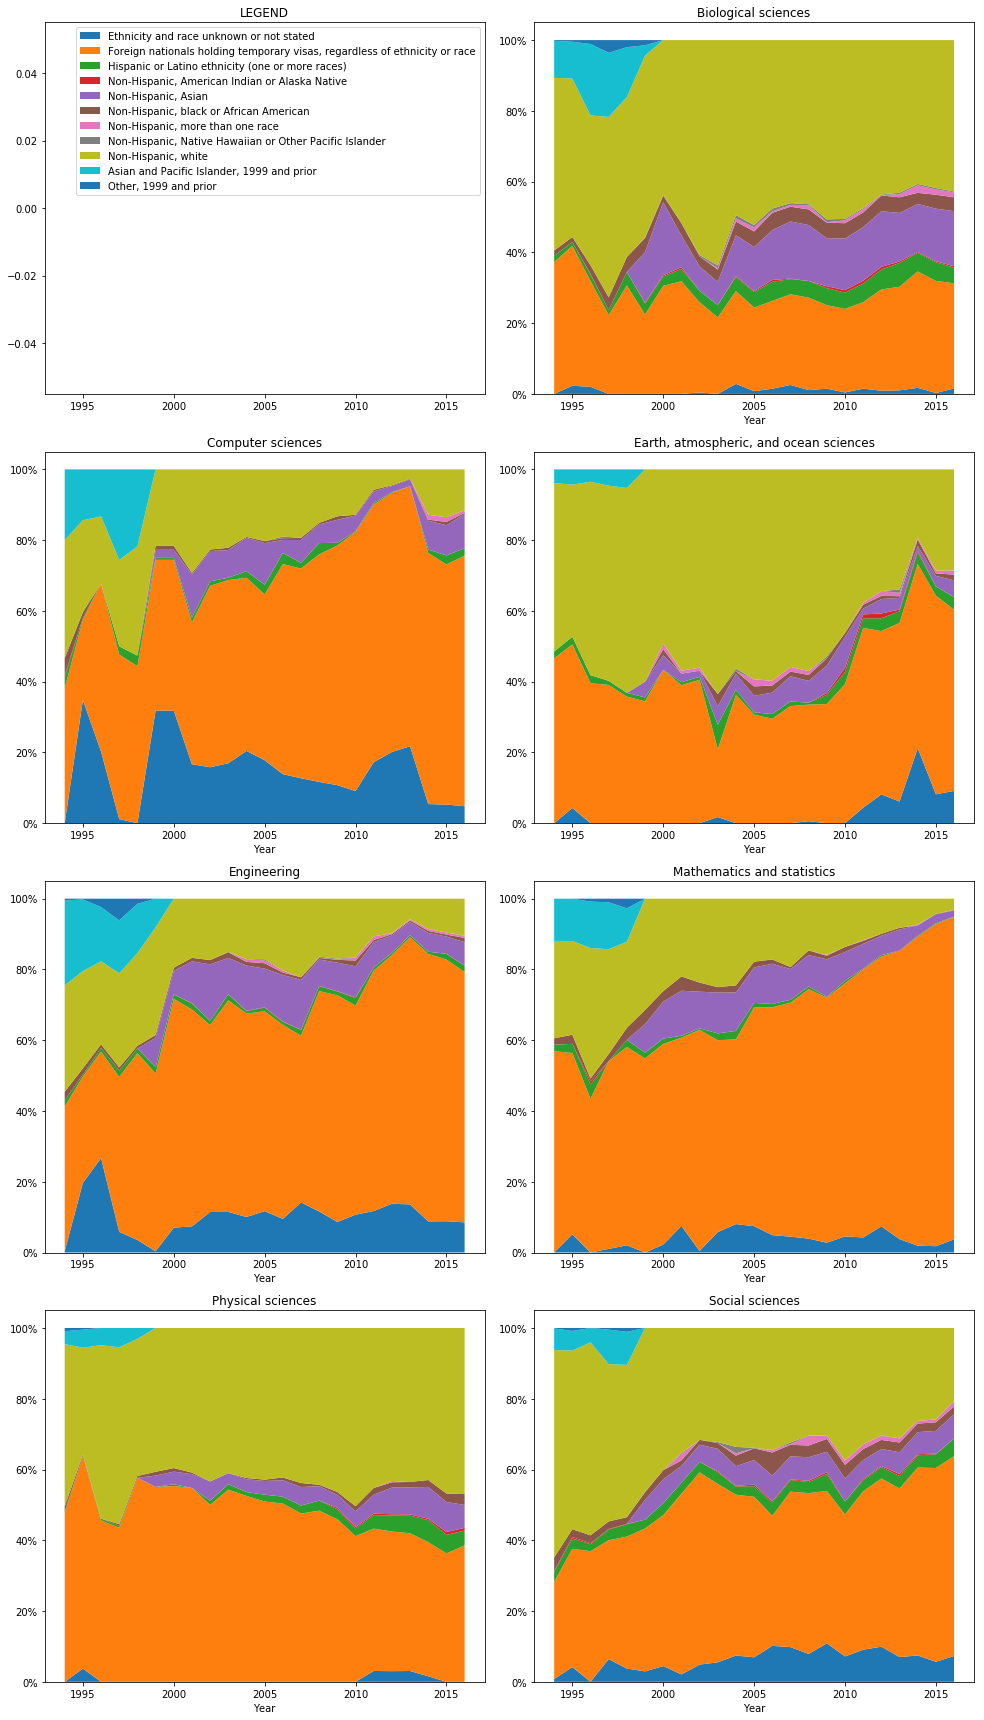

In [42]:
incompleteFields = ['Clinical medicine', 'Neurobiology and neuroscience', 'Other health', 'Psychology']
completeFields = [f for f in fields if f not in incompleteFields]

fig, ax = plt.subplots(4, 2, figsize=(14, 24))
for index, field in enumerate(completeFields):
    stack_proportions(ax[index // 2, index % 2], field, legend=(index == 0))

fig.tight_layout()

In [46]:
def plot_counts(ax, field, exclude=None, legend=False):
    for r in race_ethnicities:
        if r != exclude:
            ax.plot(
                years,
                [counts[year][field].get(r, 0) for year in years],
                label=r,
            )
    
    if legend:
        ax.legend()
        ax.set_title('LEGEND')
        return

    ax.set(title=field, xlabel='Year')

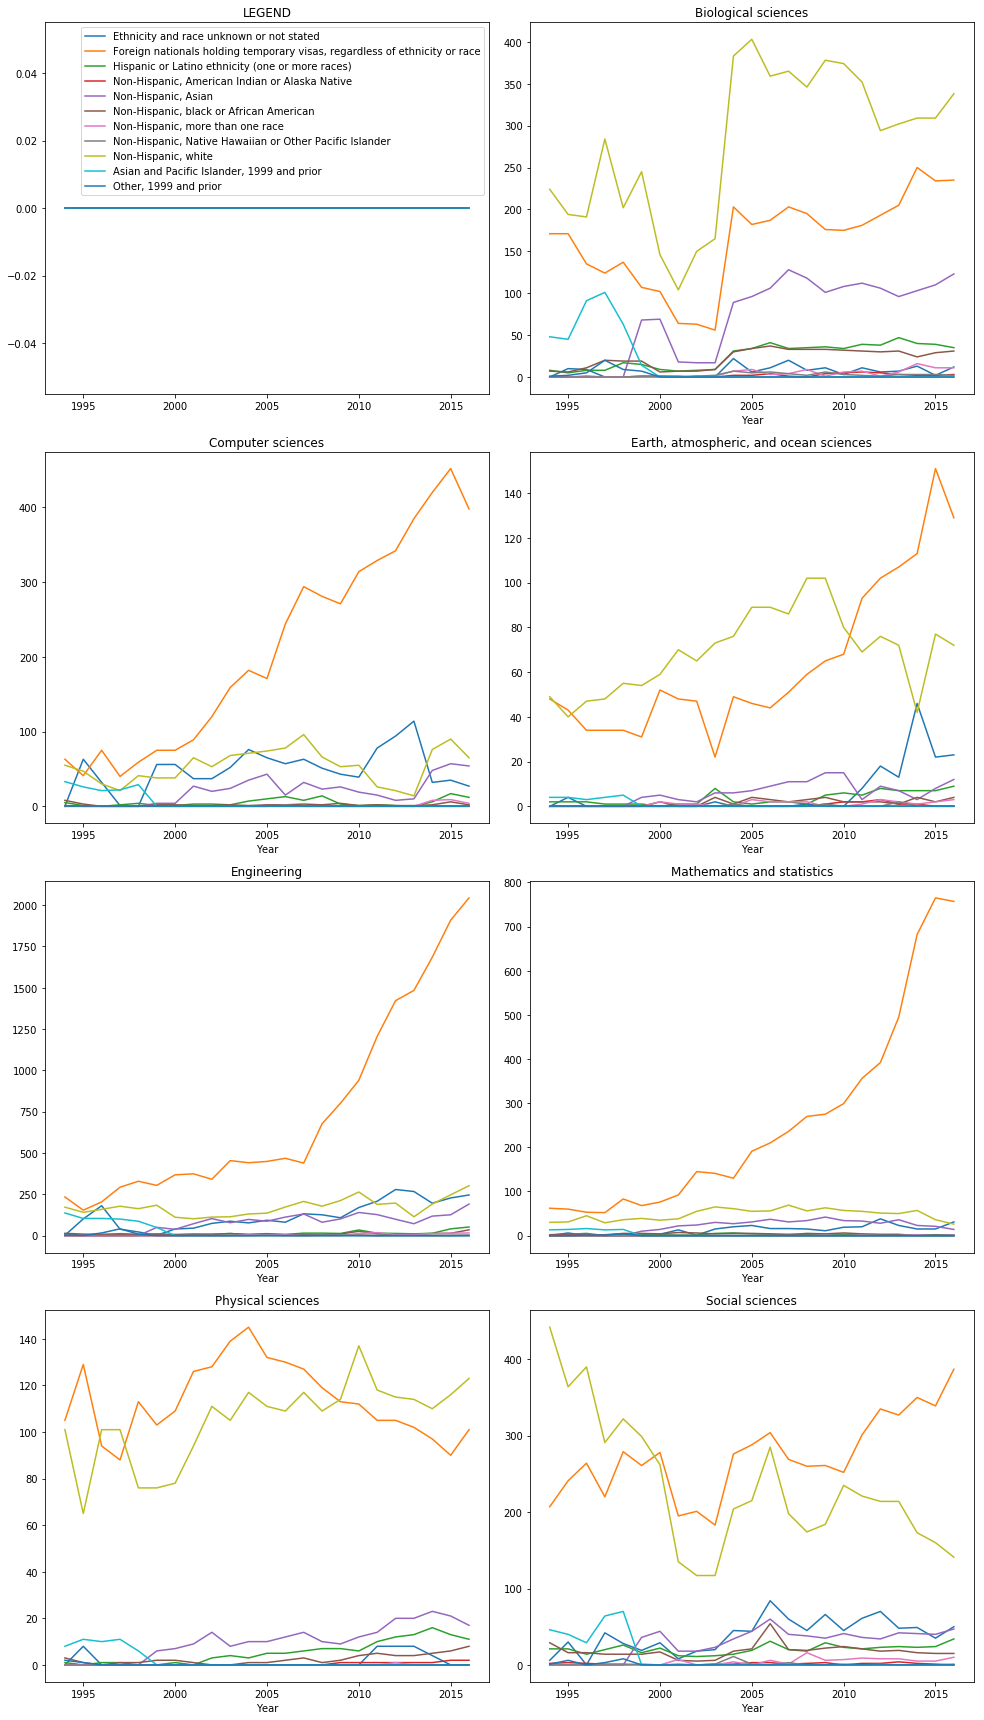

In [47]:
fig, ax = plt.subplots(4, 2, figsize=(14, 24))
for index, field in enumerate(completeFields):
    plot_counts(ax[index // 2, index % 2], field, legend=(index == 0))

fig.tight_layout()

It seems like the rise in international students may be skewing the proportions, especially in fields where the populations of the other demographic groups are relatively flat. Let's graph these fields without international students.

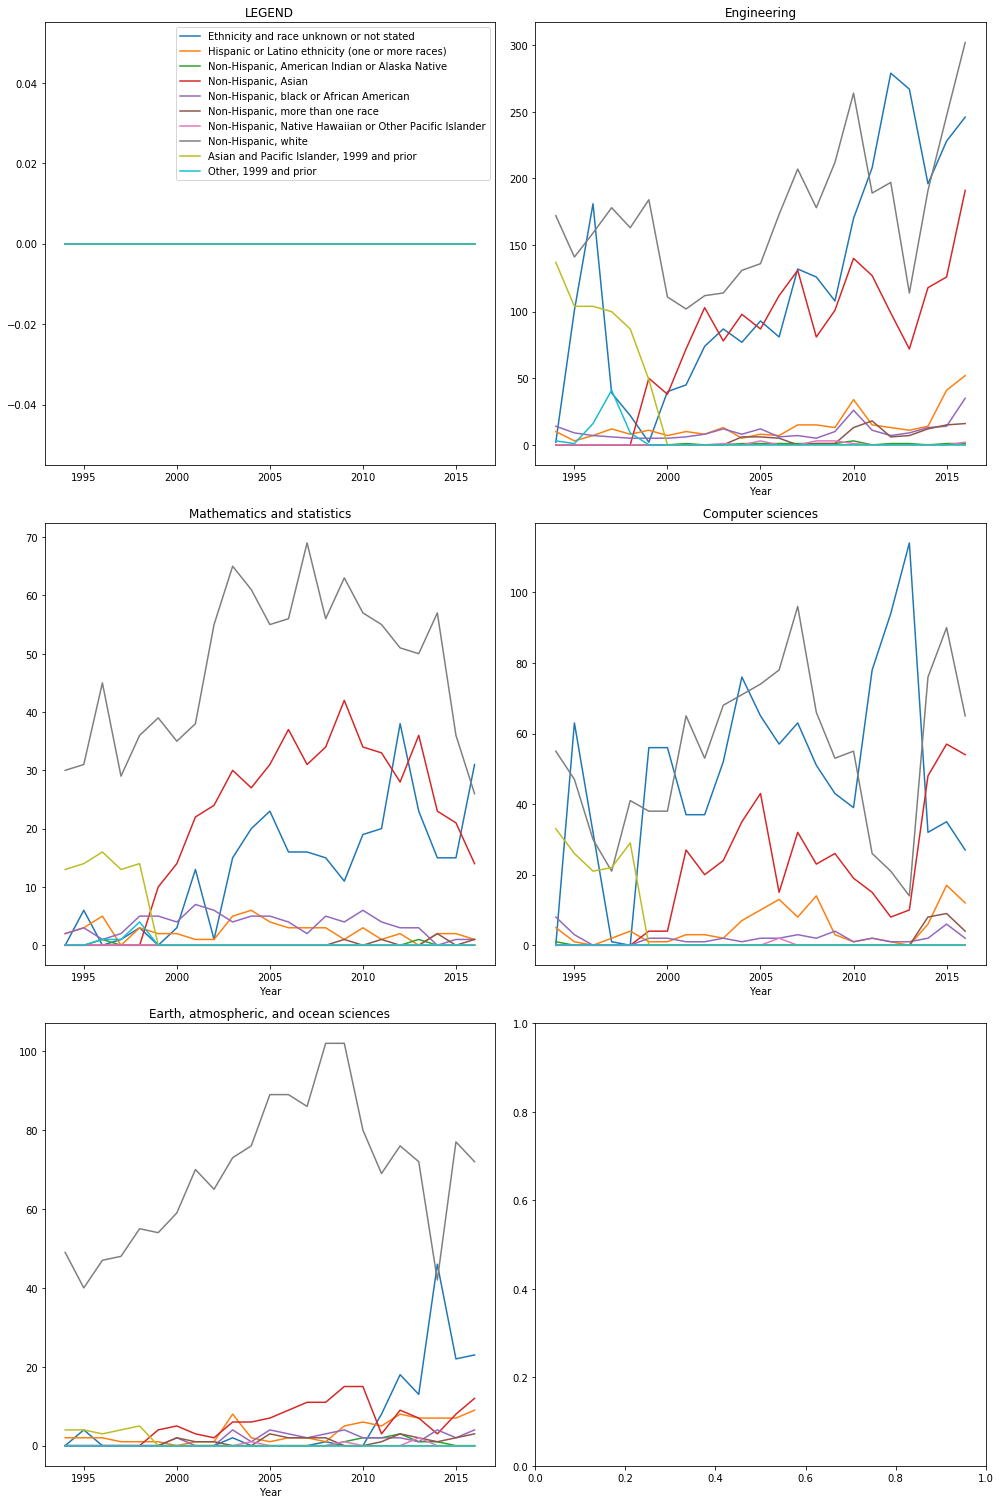

In [48]:
fields = ['Total for selected values', 'Engineering', 'Mathematics and statistics', 'Computer sciences', 'Earth, atmospheric, and ocean sciences']

fig, ax = plt.subplots(3, 2, figsize=(14, 21))
for index, field in enumerate(fields):
    plot_counts(
        ax[index // 2, index % 2],
        field,
        legend=(index == 0),
        exclude='Foreign nationals holding temporary visas, regardless of ethnicity or race'
    )

fig.tight_layout()

And, what do the stack plots look like without international students?

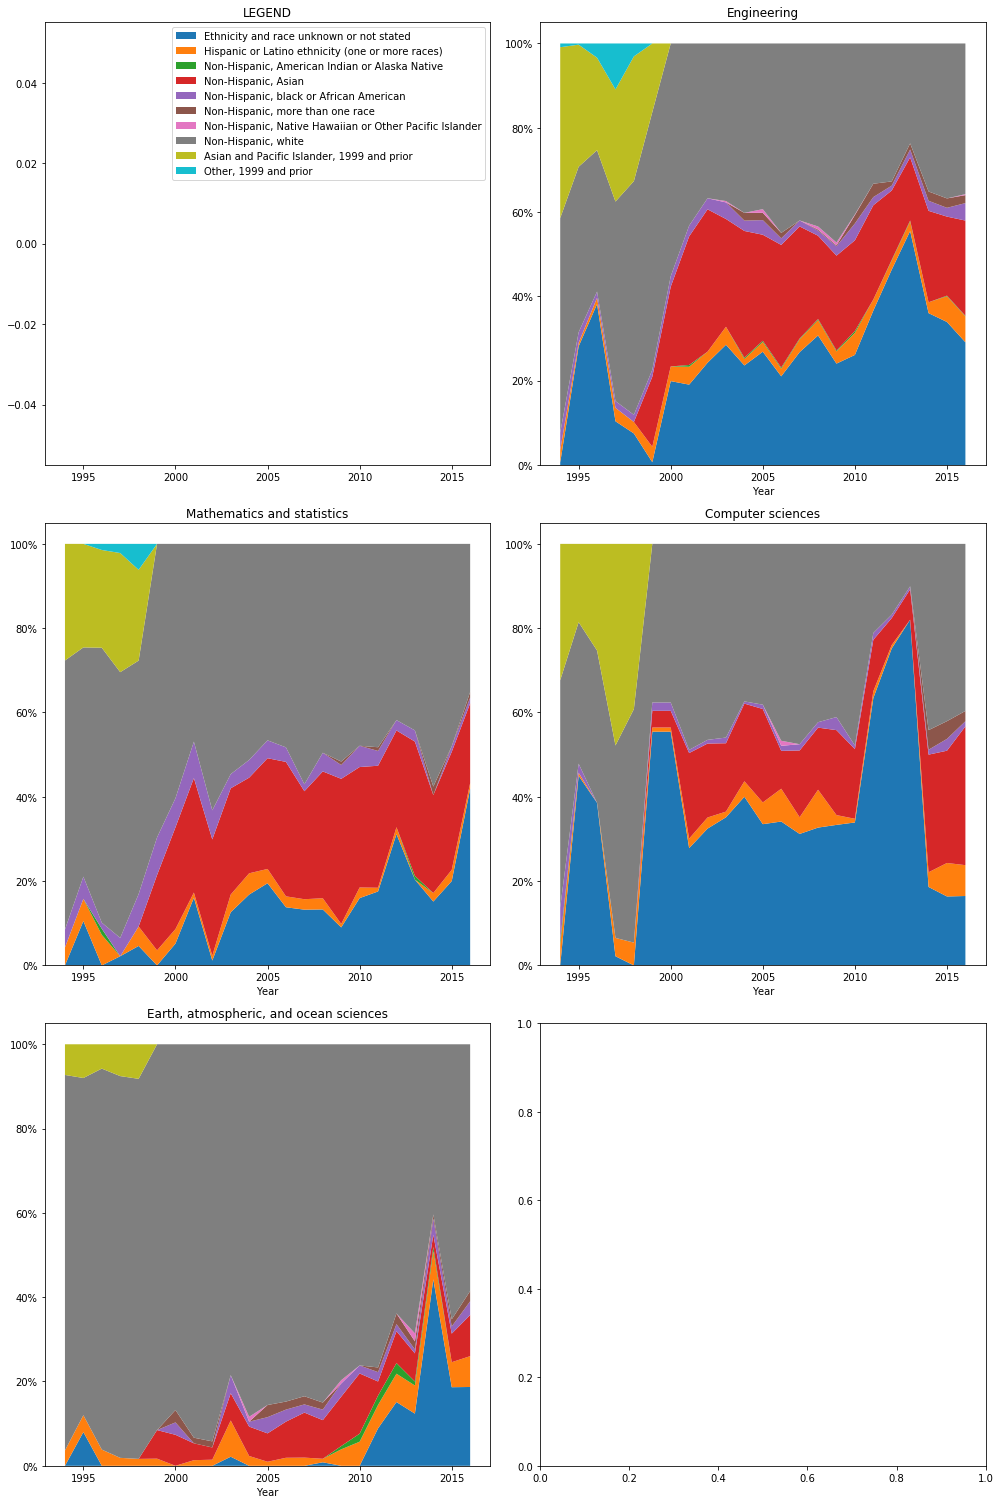

In [50]:
fields = ['Total for selected values', 'Engineering', 'Mathematics and statistics', 'Computer sciences', 'Earth, atmospheric, and ocean sciences']

fig, ax = plt.subplots(3, 2, figsize=(14, 21))
for index, field in enumerate(fields):
    stack_proportions(
        ax[index // 2, index % 2], 
        field,
        legend=(index == 0),
        exclude='Foreign nationals holding temporary visas, regardless of ethnicity or race',
    )

fig.tight_layout()

# Findings